In [167]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import ipywidgets as widgets
from ipywidgets import interact
import seaborn as sns

from utils.load_data import load_data
from utils.preprocessing import preprocess_data
from models.BaseModel import BaseModel

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [168]:
SEED = 0
EPS = 1e-6
VALID_PROPORTION = 0.2
CONFIDENCE_LEVEL = 0.95

In [169]:
data = load_data()

X, y, y_mean, y_std = preprocess_data(data=data, epsilon=EPS)

countries = data['country'].to_frame().assign(date=X['date'])

X

,date,Expense_average,Research_and_development_average,Capital_expenditure_average,Business_average,Cost_average,Tax_average,Financial_capital_average,Investment_average,Gross_domestic_product_average,...,Artificial_intelligence_average,International_Financial_Reporting_Standards_average,Employment_average,country_Canada,country_Germany,country_Japan,country_Korea,country_Switzerland,country_United Kingdom,country_United States
616,-1.771126,-1.060998,2.871241,-1.696290,1.582391,-0.732737,-0.290201,-0.604001,-0.078562,0.186376,...,-0.395035,-1.710910,1.689417,2.404072,-0.415202,-0.365754,-0.412192,-0.415202,-0.415202,-0.415202
2348,-1.771126,1.398638,0.707796,0.793092,1.231345,-1.595140,1.822169,-0.604001,1.957806,0.618893,...,-0.395035,0.652970,0.862979,-0.415202,2.404072,-0.365754,-0.412192,-0.415202,-0.415202,-0.415202
3645,-1.771126,-0.446089,2.210188,-1.696290,0.516251,0.636960,0.313333,-0.604001,0.875985,3.790688,...,-0.336456,-1.710910,1.839678,-0.415202,-0.415202,-0.365754,2.421629,-0.415202,-0.415202,-0.415202
5892,-1.771126,2.782184,-2.417180,-1.696290,1.426370,-1.290762,1.327271,-0.604001,2.530535,-3.273764,...,-0.043561,-1.710910,0.900544,-0.415202,-0.415202,-0.365754,-0.412192,2.404072,-0.415202,-0.415202
6173,-1.771126,-1.009755,2.751049,-1.696290,1.718909,-1.037115,-0.773029,1.073548,2.594171,2.276877,...,-0.277877,0.745671,2.102636,-0.415202,-0.415202,-0.365754,-0.412192,-0.415202,2.404072,-0.415202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
856,1.715275,2.116032,-0.361907,1.555148,1.114329,2.006658,3.149944,-0.222740,1.130532,1.700187,...,5.111383,0.421217,0.862979,2.404072,-0.415202,-0.365754,-0.412192,-0.415202,-0.415202,-0.415202
2588,1.715275,0.783729,-0.313831,1.605952,0.256216,2.311035,2.425703,-0.604001,1.639624,0.979325,...,4.818488,-0.459444,-0.865028,-0.415202,2.404072,-0.365754,-0.412192,-0.415202,-0.415202,-0.415202
6132,1.715275,1.808578,-1.395553,1.656756,0.841293,2.361764,3.270651,-0.604001,2.530535,1.988532,...,5.111383,-0.181340,1.464025,-0.415202,-0.415202,-0.365754,-0.412192,2.404072,-0.415202,-0.415202
6413,1.715275,-0.138634,1.248657,0.132644,0.776285,1.093526,2.727470,-0.451496,1.575987,3.574430,...,4.759909,-0.274042,1.802113,-0.415202,-0.415202,-0.365754,-0.412192,-0.415202,2.404072,-0.415202


In [170]:
y

616    -1.110615
2348   -1.219147
3645   -1.837559
5892   -0.636078
6173   -1.228650
          ...   
856     1.002158
2588    1.739899
6132    3.454888
6413    0.930596
6886    2.755538
Name: GDP, Length: 550, dtype: float64

In [171]:
n_valid = int(len(X) * VALID_PROPORTION)

X_train, y_train = X[:-n_valid], y[:-n_valid]
X_valid, y_valid = X[-n_valid:], y[-n_valid:]
country_train, country_valid = countries.iloc[:-n_valid], countries.iloc[-n_valid:]


In [172]:
model = BaseModel(seed=SEED)

model.fit(X_train, y_train)

# Predict on training and validation data
y_pred_train = model.predict(X_train)
y_pred_valid = model.predict(X_valid)

# Calculate Mean Squared Error
mse_train = mean_squared_error(y_train, y_pred_train)
mse_valid = mean_squared_error(y_valid, y_pred_valid)
print(f"Training MSE: {mse_train:.4f}")
print(f"Validation MSE: {mse_valid:.4f}")

Training MSE: 0.0019
Validation MSE: 0.7991


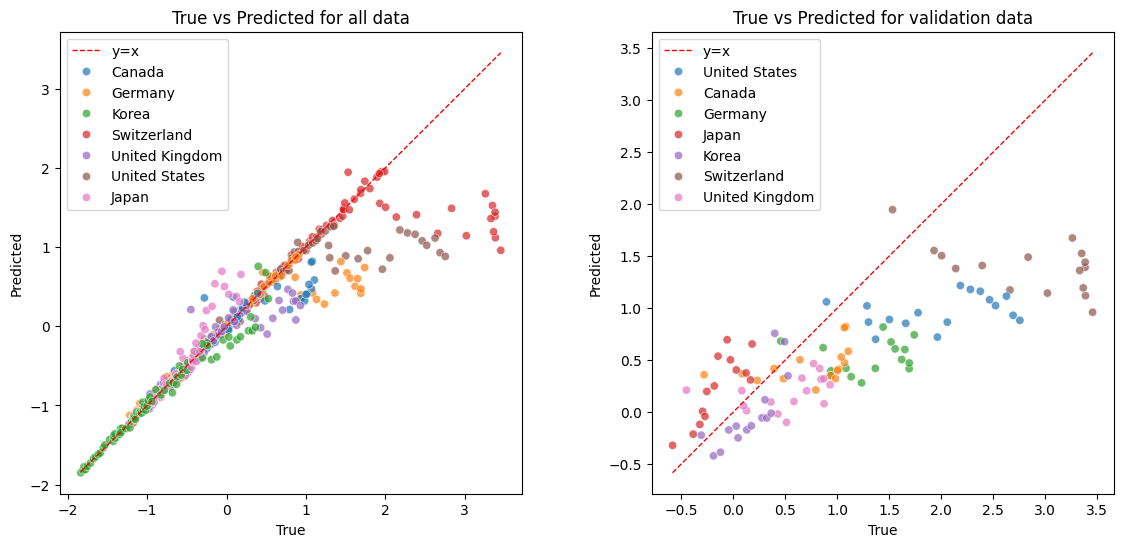

In [173]:
# Associate the result by country
y_pred_valid_country = pd.DataFrame({'date': country_valid['date'].values, 'country': country_valid['country'].values, 'y_pred': y_pred_valid, 'y_true': y_valid})
y_pred_train_country = pd.DataFrame({'date': country_train['date'].values, 'country': country_train['country'].values, 'y_pred': y_pred_train, 'y_true': y_train})

# Put together the train and the validation set
predictions = pd.concat([y_pred_train_country, y_pred_valid_country])

# Melting the dataframe for better plotting
predictions_melted = predictions.melt(
    id_vars=["date", "country"], value_vars=["y_pred", "y_true"],
    var_name="Type", value_name="Value"
)

plt.figure(figsize=(14, 6))

ax = plt.subplot(1, 2, 1)
ax.set_box_aspect(1)

plt.plot([np.min(predictions['y_true']), np.max(predictions['y_true'])], [np.min(predictions['y_true']), np.max(predictions['y_true'])], color='red', linewidth=1, linestyle='--', label='y=x')
sns.scatterplot(x='y_true', y='y_pred', data=predictions, hue='country', alpha=0.7)
plt.title('True vs Predicted for all data')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.legend()

ax = plt.subplot(1, 2, 2)
ax.set_box_aspect(1)

plt.plot([np.min(y_pred_valid_country['y_true']), np.max(y_pred_valid_country['y_true'])], [np.min(y_pred_valid_country['y_true']), np.max(y_pred_valid_country['y_true'])], color='red', linewidth=1, linestyle='--', label='y=x')
sns.scatterplot(x='y_true', y='y_pred', data=y_pred_valid_country, hue='country', alpha=0.7)
plt.title('True vs Predicted for validation data')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.legend()

plt.show()

In [174]:
# Function to plot data with confidence intervals for the selected country
def plot_by_country_with_confidence(selected_country):
    filtered_data = predictions_melted[predictions_melted["country"] == selected_country]
    cutoff_date = filtered_data['date'].quantile(1-VALID_PROPORTION)

    plt.figure(figsize=(12, 6))
    
    # Plot predictions and true values
    sns.lineplot(
        data=filtered_data,
        x="date", y="Value", hue="Type", style="Type", markers=True, dashes=False
    )

    # Add a vertical line to indicate where validation starts
    plt.axvline(x=cutoff_date, color='red', linestyle='--', label=f'Validation Start ({(1-VALID_PROPORTION)*100:.0f}%)')
    
    # Enhancing the plot
    plt.title(f"Prediction vs True Values for {selected_country}")
    plt.xlabel("Date")
    plt.ylabel("Values")
    plt.legend(title="Legend")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Create a dropdown widget for selecting the country
countries = predictions["country"].unique()
dropdown = widgets.Dropdown(
    options=countries,
    value=countries[0],
    description='Country:'
)

# Use the interact function to link the dropdown with the updated plot function
interact(plot_by_country_with_confidence, selected_country=dropdown)

interactive(children=(Dropdown(description='Country:', options=('Canada', 'Germany', 'Korea', 'Switzerland', '…

<function __main__.plot_by_country_with_confidence(selected_country)>

In [175]:
# OLD

import shap

PLOT_SHAP = False

if PLOT_SHAP:
    explainer = shap.KernelExplainer(model.predict, shap.kmeans(X_train, 20))
    shap_values = explainer(X_test)
    shap.summary_plot(shap_values, X_test)
